# Early Models

This notebook will primarily focus on looking at a collection of simpler models using the combined collisions/traffic flow dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

##### 0. Importing and cleaning the data

In [4]:
## Read in the data with traffic counter and
## bike feature information matched
data_raw = pd.read_csv('./DataFrames/df_road_v3.csv')

In [7]:
data_raw.sample(5)

,ID,total,slight,serious,neigh,Road_name,Road_name2,h,Day_of_Week,m,...,aadf_All_HGVs,aadf_LGVs,aadf_Buses_and_coaches,total_dnorm,total_dnorm_bvnorm,serious_ratio,N_year,Year_start,Year_end,Max_year_gap
415,56869,26,20,6,0,A315,U,16,6,5,...,293.269231,1217.538462,993.807692,21.950773,16.764723,0.230769,22,2000,2021,1
1116,6785,8,8,0,0,A224,U,11,3,5,...,428.500000,2393.875000,124.625000,4.239398,24.771906,0.000000,22,2000,2021,1
1548,17570,3,3,0,0,A217,A217,6,5,11,...,1032.333333,5357.000000,1224.333333,20.032453,3.446391,0.000000,22,2000,2021,1
1485,48768,4,3,1,0,A121,na0,16,3,1,...,1064.000000,3931.250000,220.250000,2.249582,1.712917,0.250000,22,2000,2021,1
81,7671,73,63,10,13,A4200,A4200,9,5,7,...,960.739726,2891.424658,1480.575342,73.870582,10.309962,0.136986,18,2000,2017,1


In [5]:
## Features to ignore when dropping NaN values
## because only the traffic counter data should
## be required to match accident data
bike_features = ['aadf_FEATURE_ID', 'aadf_SVDATE', 'aadf_CLT_CARR', 
                     'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
                     'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
                     'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
                     'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
                     'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_CLT_ACCESS',
                     'aadf_CLT_COLOUR', 'aadf_BOROUGH']

For now, we will ignore any additional time columns and neighborhood work from Greg because it gets transformed when summing and the mode is taken anyway, making them virtually useless columns.

In [14]:
## Identify potential regression columns
#reg_features = ['Longitude', 'Latitude', 'Day_of_Week',
#                    'Time', 'Road_Type', 'Speed_limit',
#                    'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
#                    'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
#                    'aadf_Year', 'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
#                    'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 
#                    'aadf_CLT_PARSEG', 'aadf_CLT_SHARED', 'aadf_CLT_MANDAT',
#                    'aadf_CLT_ADVIS', 'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 
#                    'aadf_CLT_BIDIRE', 'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 
#                    'aadf_CLT_PARKR', 'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 
#                    'aadf_CLT_ACCESS', 'distance_to_cp']

reg_features = ['aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
                    'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 
                    'aadf_CLT_PARSEG', 'aadf_CLT_SHARED', 'aadf_CLT_MANDAT',
                    'aadf_CLT_ADVIS', 'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 
                    'aadf_CLT_BIDIRE', 'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 
                    'aadf_CLT_PARKR', 'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 
                    'distance_to_cp', 'bikelane']

reg_col = 'total'
class_col = 'Accident_Severity'

In [15]:
data_raw[reg_features]

,Speed_limit,aadf_Pedal_cycles,aadf_All_motor_vehicles,aadf_CLT_CARR,aadf_CLT_SEGREG,aadf_CLT_STEPP,aadf_CLT_PARSEG,aadf_CLT_SHARED,aadf_CLT_MANDAT,aadf_CLT_ADVIS,aadf_CLT_PRIORI,aadf_CLT_CONTRA,aadf_CLT_BIDIRE,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,distance_to_cp,bikelane
0,30,2435.000000,39430.787671,True,True,True,False,False,False,True,True,False,False,False,True,False,False,False,0.259487,True
1,30,1247.848797,21157.721649,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,0.215577,True
2,30,3585.992188,21983.050781,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,0.219738,True
3,30,2677.780591,24195.257384,True,True,False,True,True,True,True,True,False,False,False,True,False,False,True,0.267128,True
4,30,2473.373272,17012.562212,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,0.237963,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,-9,138.000000,6714.000000,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,-9.000000,True
4057,-9,10.000000,95.000000,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,-9.000000,True
4058,-9,32.000000,9508.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-9.000000,False
4059,-9,22.000000,190.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-9.000000,False


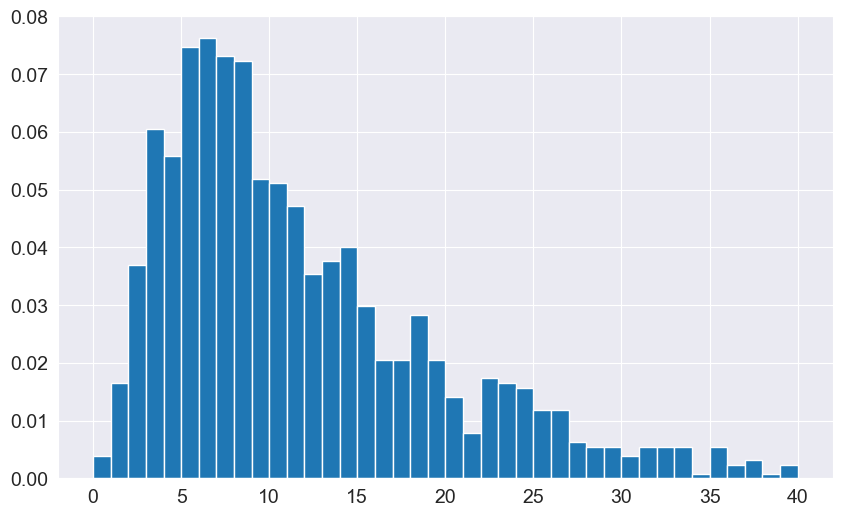

In [38]:
plt.figure(figsize=(10,6))

plt.hist(data_raw.loc[data_raw.total > 5].total_dnorm_bvnorm, bins=40, range=[0,40], density=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [28]:
## import StandardScaler
from sklearn.preprocessing import StandardScaler

In [49]:
## Make a scaler object
scaler = StandardScaler()

## fit the scaler
data_raw[['aadf_Pedal_cycles_scaled', 'aadf_All_motor_vehicles_scaled', 'distance_to_cp_scaled']] = scaler.fit_transform(data_raw[['aadf_Pedal_cycles', 'aadf_All_motor_vehicles', 'distance_to_cp']])

In [50]:
reg_features = ['aadf_Pedal_cycles_scaled', 'aadf_All_motor_vehicles_scaled',
                    'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 
                    'aadf_CLT_PARSEG', 'aadf_CLT_SHARED', 'aadf_CLT_MANDAT',
                    'aadf_CLT_ADVIS', 'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 
                    'aadf_CLT_BIDIRE', 'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 
                    'aadf_CLT_PARKR', 'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 
                    'distance_to_cp_scaled', 'bikelane']

data = data_raw.copy()

##### 1. Ridge and Lasso Regression

In [39]:
from sklearn.linear_model import Lasso, Ridge

In [51]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000]

## make coefficient holder
lasso_coefs = np.zeros((len(alphas), len(reg_features)))
ridge_coefs = np.zeros((len(alphas), len(reg_features)))

# Temporary fix
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data.dropna(inplace=True)

## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    ridge = Ridge(alpha=alphas[i], max_iter=10000000)
    
    ## fit model
    lasso.fit(data[reg_features], data.total_dnorm_bvnorm)
    ridge.fit(data[reg_features], data.total_dnorm_bvnorm)
    
    ## record coefs
    lasso_coefs[i,:] = lasso.coef_
    ridge_coefs[i,:] = ridge.coef_
    

In [52]:
pd.DataFrame(lasso_coefs, index=alphas, columns=reg_features)

,aadf_Pedal_cycles_scaled,aadf_All_motor_vehicles_scaled,aadf_CLT_CARR,aadf_CLT_SEGREG,aadf_CLT_STEPP,aadf_CLT_PARSEG,aadf_CLT_SHARED,aadf_CLT_MANDAT,aadf_CLT_ADVIS,aadf_CLT_PRIORI,aadf_CLT_CONTRA,aadf_CLT_BIDIRE,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,distance_to_cp_scaled,bikelane
0.000001,-4.870594,8.049626,-7.407047,-2.678452,-1.235320,3.891604,-13.376446,0.204114,-2.533056,1.359786,4.472502,3.217820,-7.320803,1.262099,-1.810010,-0.175539,7.327845,-129.249425,8.059435
0.000010,-4.870549,8.049613,-7.406576,-2.678245,-1.234907,3.891588,-13.376071,0.204014,-2.532954,1.359612,4.472333,3.217629,-7.320072,1.261248,-1.809925,-0.174816,7.327537,-129.242205,8.059047
0.000100,-4.870088,8.049486,-7.401855,-2.676162,-1.230771,3.891439,-13.372327,0.203016,-2.531950,1.357867,4.470636,3.215690,-7.312759,1.252734,-1.809077,-0.167591,7.324436,-129.169942,8.055182
0.001000,-4.865511,8.048229,-7.355124,-2.655524,-1.189452,3.889714,-13.335353,0.192976,-2.521733,1.340473,4.453864,3.196713,-7.239624,1.167835,-1.800687,-0.095368,7.293890,-128.448793,8.016860
0.010000,-4.818503,8.037836,-6.898726,-2.450455,-0.760802,3.866442,-12.957556,0.111404,-2.427646,1.173556,4.277873,3.027561,-6.553512,0.349093,-1.691390,-0.000000,6.989896,-121.245858,7.636830
0.100000,-4.462023,7.891974,-2.553039,-0.635388,-0.000000,3.427139,-9.111118,-0.000000,-1.832955,0.000000,2.777139,1.372662,-0.069100,-0.000000,-0.554214,0.000000,4.003800,-50.872302,3.892447
0.250000,-4.049159,7.522008,-0.000000,-0.000000,-0.000000,2.774211,-4.120240,0.000000,-0.434952,-0.000000,1.090240,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.618799,-0.000000,0.000000
0.500000,-3.920933,6.963573,-0.000000,0.000000,-0.000000,0.690194,-2.178204,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
0.750000,-3.882894,6.394666,-0.000000,0.000000,-0.000000,0.000000,-0.903364,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
1.000000,-3.829299,5.796446,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [53]:
pd.DataFrame(ridge_coefs, index=alphas, columns=reg_features)

,aadf_Pedal_cycles_scaled,aadf_All_motor_vehicles_scaled,aadf_CLT_CARR,aadf_CLT_SEGREG,aadf_CLT_STEPP,aadf_CLT_PARSEG,aadf_CLT_SHARED,aadf_CLT_MANDAT,aadf_CLT_ADVIS,aadf_CLT_PRIORI,aadf_CLT_CONTRA,aadf_CLT_BIDIRE,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,distance_to_cp_scaled,bikelane
0.000001,-4.870599,8.049627,-7.407098,-2.678475,-1.235366,3.891606,-13.376486,0.204125,-2.533067,1.359805,4.472521,3.217841,-7.320884,1.262192,-1.810019,-0.175619,7.327879,-129.250176,8.059477
0.000010,-4.870597,8.049627,-7.407087,-2.678473,-1.235363,3.891606,-13.376480,0.204125,-2.533066,1.359801,4.472522,3.217842,-7.320879,1.262187,-1.810022,-0.175617,7.327877,-129.249724,8.059473
0.000100,-4.870577,8.049625,-7.406976,-2.678453,-1.235334,3.891613,-13.376419,0.204123,-2.533050,1.359763,4.472532,3.217842,-7.320826,1.262132,-1.810049,-0.175604,7.327853,-129.245211,8.059430
0.001000,-4.870377,8.049607,-7.405866,-2.678255,-1.235044,3.891684,-13.375814,0.204103,-2.532889,1.359381,4.472638,3.217851,-7.320297,1.261581,-1.810317,-0.175464,7.327615,-129.200098,8.059002
0.010000,-4.868384,8.049429,-7.394809,-2.676281,-1.232161,3.892390,-13.369779,0.203905,-2.531291,1.355582,4.473685,3.217937,-7.315024,1.256099,-1.812992,-0.174077,7.325243,-128.750691,8.054734
0.100000,-4.849180,8.047675,-7.287972,-2.657162,-1.204409,3.899136,-13.311177,0.201988,-2.515926,1.318988,4.483617,3.218601,-7.263504,1.203252,-1.838703,-0.160684,7.302033,-124.422420,8.013181
0.250000,-4.819861,8.044871,-7.123680,-2.627604,-1.162149,3.909245,-13.219974,0.199011,-2.492580,1.263171,4.498177,3.218998,-7.182136,1.122462,-1.877744,-0.140126,7.265216,-117.819689,7.948096
0.500000,-4.777271,8.040470,-6.882074,-2.583732,-1.101040,3.923443,-13.083111,0.194565,-2.458942,1.182227,4.517797,3.218011,-7.057170,1.004856,-1.933906,-0.110002,7.208248,-108.242792,7.849404
0.750000,-4.740996,8.036346,-6.672943,-2.545291,-1.049301,3.934978,-12.961532,0.190644,-2.430596,1.113438,4.532752,3.215381,-6.943113,0.904423,-1.981103,-0.084068,7.155745,-100.102507,7.760617
1.000000,-4.709715,8.032441,-6.489554,-2.511150,-1.004961,3.944410,-12.852090,0.187144,-2.406420,1.054256,4.544030,3.211469,-6.837887,0.817594,-2.021206,-0.061471,7.106820,-93.098173,7.679725


##### 2. Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
slr = LinearRegression(copy_X=True)

slr.fit(data[reg_features], data.total_dnorm_bvnorm)

residuals = data.total_dnorm_bvnorm - slr.predict(data[reg_features])

In [66]:
residuals

0         5.717280
1        12.834455
2        10.302045
3         9.246297
4        14.999187
           ...    
1955     -0.504194
1956    -15.018991
1957    -14.430306
1959     -9.711170
1960    215.398218
Name: total_dnorm_bvnorm, Length: 1932, dtype: float64

##### 3. GridSearchCV

In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [56]:
grid_cv = GridSearchCV(KNeighborsRegressor(), 
                         param_grid = {'n_neighbors':range(1,50),
                                          'weights':['uniform', 'distance']}, 
                         scoring = 'neg_mean_squared_error',
                         cv = KFold(5, shuffle=True, random_state = 30293))

In [57]:
grid_cv.fit(data[reg_features], data.total_dnorm_bvnorm)

GridSearchCV(cv=KFold(n_splits=5, random_state=30293, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [59]:
grid_cv.best_params_

{'n_neighbors': 39, 'weights': 'distance'}

In [61]:
grid_cv.best_estimator_.predict(data[reg_features])

array([ 14.29557687,  33.46272172,  10.04982925, ...,   7.76645533,
         1.14408435, 244.98227209])